Let $\psi$ be the bijection from the set of permutations of size $n$ $S_n$ to the set of Dyck paths $\mathcal{D}_n$. This is described in the book thru arranging non-attacking rooks on a chess board of size $n$ - we implement it below:

In [1]:
from typing import *
from numba import njit

Permutation = List[int]
DyckPath = List[List[int]]

@njit
def psi(perm: Permutation) -> DyckPath:
    N = len(perm); perm = [i-1 for i in perm]
    chessboard = [[' ' for _ in range(N)] for _ in range(N)]
    # Place rooks in positions corresponding to permutation
    # if w(i) = j, put a rook in column i (from left toright), row j (from bottom to top).
    for i, p in enumerate(perm):
        chessboard[N-1-p][i] = 'X'
        for j in range(N-1-p):
            chessboard[j][i] = '.'
        for j in range(i):
            chessboard[N-1-p][j] = '.'
    return chessboard

def pretty_print(dyck_path: DyckPath):
    for row in dyck_path:
        for cell in row:
            print(cell, end=' ')
        print()

def get_area(dyck_path: DyckPath) -> int:
    return sum ( len( "".join(row).strip() ) for row in dyck_path )

def sanity_tests():
    # Use Figure 2.8 as a sanity test
    perm = [9,7,1,3,2,6,4,5,8]
    assert [ "".join(row) for row in psi(perm) ] == [
        'X........',
        '........X',
        '.X...... ',
        '.....X.. ',
        '.......X ',
        '......X  ',
        '...X.    ',
        '....X    ',
        '..X      '
    ]
    assert get_area( psi(perm) ) == 62
    return True
assert sanity_tests()

Next, let $A_n: S_n \to \mathbb{N}$ be defined by the *area* of a permutation under $\psi$ - for example, in the code above, we have:

$A\left( \; (9,7,1,3,2,6,4,5,8)\; \right) = \text{area}(\; \psi(9,7,1,3,2,6,4,5,8)\; ) $
$$ = \text{area}\left( \begin{array}{ccccccccc}
X & x & x & x & x & x & x & x & x \\
x & x & x & x & x & x & x & x & X \\
x & X & x & x & x & x & x & x &  \\
x & x & x & x & x & X & x & x &  \\
x & x & x & x & x & x & x & X &  \\
x & x & x & x & x & x & X &   &  \\
x & x & x & X & x &   &   &   &  \\
x & x & x & x & X &   &   &   &  \\
x & x & X &   &   &   &   &   &  \\
 \end{array}\right) = 62$$

Note that the maximum possible area for $A_n(\pi)$ for any $\pi \in S_n$ is if all $n^2$ cells are filled: we can therefore divide thru by this and construct a new *normalized area function*, say 
$$ \begin{align*}
\hat{A}_n: S_n &\to \mathbb{R} \\
\pi &\mapsto \frac{\text{area}( \psi(\pi) )}{n^2}
\end{align*}
$$

This defines a variant of a *permutation statistic* (here our range is the reals, so this is more of a distribution - our original $\hat{A}$ was a permutation statistic in the strictest definition). Below are plots of the distributions of $\hat{A}$ for $n=2$ to $11$.
 

n = 2
n = 3
n = 4
n = 5
n = 6
n = 7
n = 8
n = 9
n = 10
n = 11


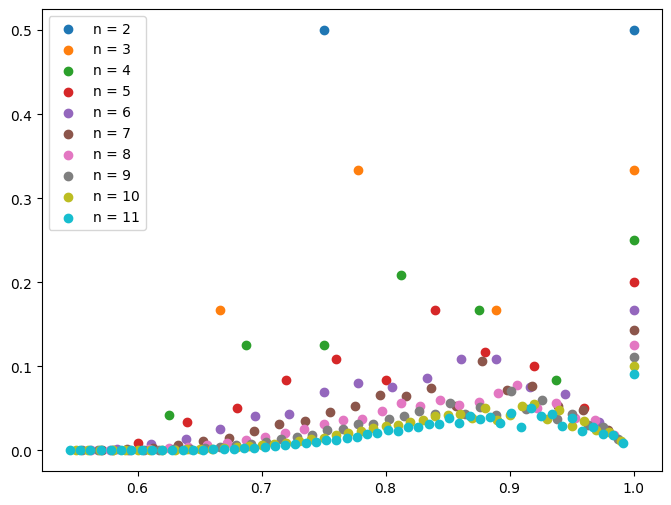

In [3]:
from collections import Counter
from itertools import permutations
from tqdm import tqdm_notebook as tqdm
from fractions import Fraction as F
from math import factorial
from numba import jit
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt

def worker(p):
    return get_area(psi(p))

def get_areas(permutations):
    with Pool(processes=cpu_count()) as pool:
        results = list( pool.map(worker, permutations) )
    return results

data = dict()
for n in range(2, 12):
    print(f"n = {n}")
    area_counts = Counter( [F(area, n*n) for area in get_areas(permutations(range(1,n+1))) ] )
    #areas = Counter([F( get_area(psi(perm)) , n*n) for perm in tqdm(permutations(range(1,n+1)))])
    data[n] = [(float(rat), cnt/factorial(n)) for rat, cnt in area_counts.items()]

print('[+ ]')
fig, ax = plt.subplots(figsize=(8, 6))
for n, data in data.items():
    x, y = zip(*data)
    ax.scatter(x, y, label=f'n = {n}')
ax.legend()
plt.show()

We note several things about the family of distributions $\hat{A}_n$. (Can we come up with proofs of these? Left as exercise.)
 - $\max(\hat{A}_n) = 1$ is achieved for every $1$ in $n$ elements in $S_n$
 - $\min(\hat{A}_n) = \frac{n+1}{2n}$ is achieved for only $1$ element in $S_n$
(Note that these two facts imply that as $ n \to \infty$, $\hat{A}_n$ becomes a distribution on $(1/2, 1)$)
A natural question to ask is - what is the mean of this distribution? That is - what does $M_n = \frac{1}{n!} \sum_{\pi \in S_n} \hat{A}_n(\pi)$ look like? We try to answer this by running a [Monte-Carlo type simulation](https://en.wikipedia.org/wiki/Monte_Carlo_method) on all $ n \le 50 $ and plot the average value of $\hat{A}_n$ versus $n$

```python
from statistics import mean, stdev
from random import shuffle, seed
import numpy as np
from itertools import count, islice

seed(0)

def worker(p):
    return get_area(psi(p))

def get_areas(permutations):
    with Pool(processes=cpu_count()) as pool:
        results = list( pool.map(worker, permutations) )
    return results

MAX_LEN = 5*10**6
CHUNK_SIZE = 10000
def monte_carlo_mean(n):
    # Return (mean, std.dev of M_n)
    if factorial(n) < MAX_LEN:
        return ( mean(get_areas( permutations(range(1, n+1)) ))/(n*n), 0 )
    else:
        def permutation_iterator():
            for i in range(MAX_LEN):
                yield list( np.random.permutation(n)+1 )
        with Pool(processes=cpu_count()-2) as pool:
            it = permutation_iterator()
            areas = [] 
            # areas = [a / n*n for a in tqdm( pool.map(worker, permutation_iterator()))  ]
            for _ in range(MAX_LEN//CHUNK_SIZE):
                chunk = list(islice(it, CHUNK_SIZE))
                if chunk:
                    areas += [a / (n*n) for a in  pool.map(worker, chunk) ]
            return  (mean(areas), stdev(areas))

x = list( range(2, 50) ) + [60, 70, 80, 90, 100]
avgs = []
stdevs = []
for n in x:
    print(f"{n}...", end = "")
    data = monte_carlo_mean(n)
    avgs.append(data[0]); stdevs.append(data[1])
plt.errorbar(x, avgs, yerr=stdevs, fmt='o-', capsize=5, )
plt.axhline(y=1, color='red', linestyle='dashed', linewidth=1,)
plt.ylim(min(avgs) - 0.05, 1+0.05)
```

This takes a while - we get the following plot:

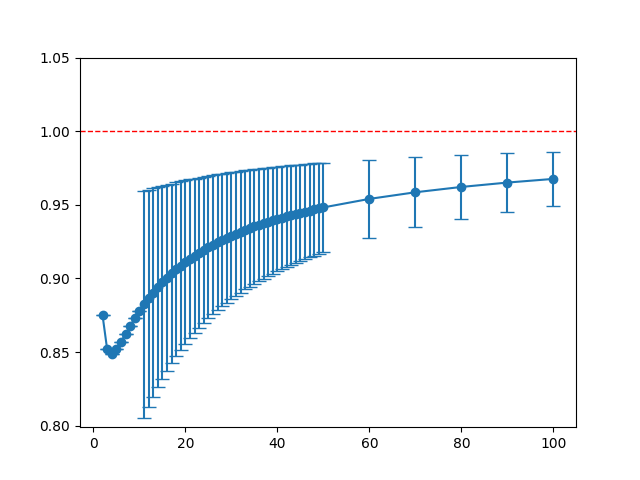

In [1]:
from IPython.display import Image

Image("./out.png")

**CONJECTURE**: We have that $ \lim_{n \to \infty } M_n = 1$